In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from pathlib import Path

# Set up matplotlib for inline plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
data_path = Path("BraTS2021/BraTS2021_Training_Data")
case_dirs = sorted(list(data_path.glob("BraTS2021_*")))

print(f"Found {len(case_dirs)} cases")
print(f"First few cases: {[c.name for c in case_dirs[:5]]}")

Found 1251 cases
First few cases: ['BraTS2021_00000', 'BraTS2021_00002', 'BraTS2021_00003', 'BraTS2021_00005', 'BraTS2021_00006']


In [3]:
case_dir = case_dirs[0]  # First case
case_name = case_dir.name

print(f"Loading case: {case_name}")
print(f"Files in case:")
for f in sorted(case_dir.glob("*.nii.gz")):
    print(f"  {f.name}")

Loading case: BraTS2021_00000
Files in case:
  BraTS2021_00000_flair.nii.gz
  BraTS2021_00000_seg.nii.gz
  BraTS2021_00000_t1.nii.gz
  BraTS2021_00000_t1ce.nii.gz
  BraTS2021_00000_t2.nii.gz


In [4]:
t1 = nib.load(case_dir / f"{case_name}_t1.nii.gz").get_fdata()
t1ce = nib.load(case_dir / f"{case_name}_t1ce.nii.gz").get_fdata()
t2 = nib.load(case_dir / f"{case_name}_t2.nii.gz").get_fdata()
flair = nib.load(case_dir / f"{case_name}_flair.nii.gz").get_fdata()
seg = nib.load(case_dir / f"{case_name}_seg.nii.gz").get_fdata()

print(f"Data shape: {t1.shape}")
print(f"T1 range: [{t1.min():.1f}, {t1.max():.1f}]")
print(f"Segmentation labels: {np.unique(seg)}")

Data shape: (240, 240, 155)
T1 range: [0.0, 2023.0]
Segmentation labels: [0. 1. 2. 4.]


Slice with most tumor: 74
Tumor pixels in best slice: 1978


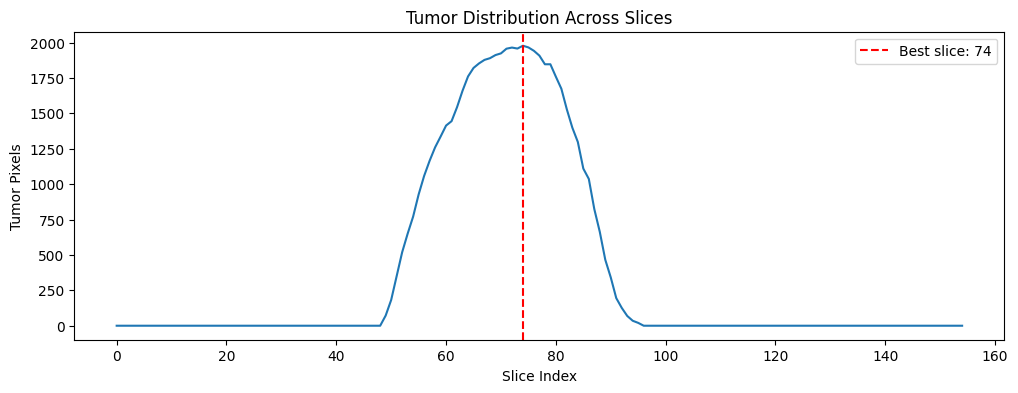

In [5]:
tumor_per_slice = []
for i in range(seg.shape[2]):
    tumor_pixels = np.sum(seg[:, :, i] > 0)
    tumor_per_slice.append(tumor_pixels)

best_slice = np.argmax(tumor_per_slice)
print(f"Slice with most tumor: {best_slice}")
print(f"Tumor pixels in best slice: {tumor_per_slice[best_slice]}")

# Plot tumor distribution across slices
plt.figure(figsize=(12, 4))
plt.plot(tumor_per_slice)
plt.axvline(best_slice, color='red', linestyle='--', label=f'Best slice: {best_slice}')
plt.xlabel('Slice Index')
plt.ylabel('Tumor Pixels')
plt.title('Tumor Distribution Across Slices')
plt.legend()
plt.show()

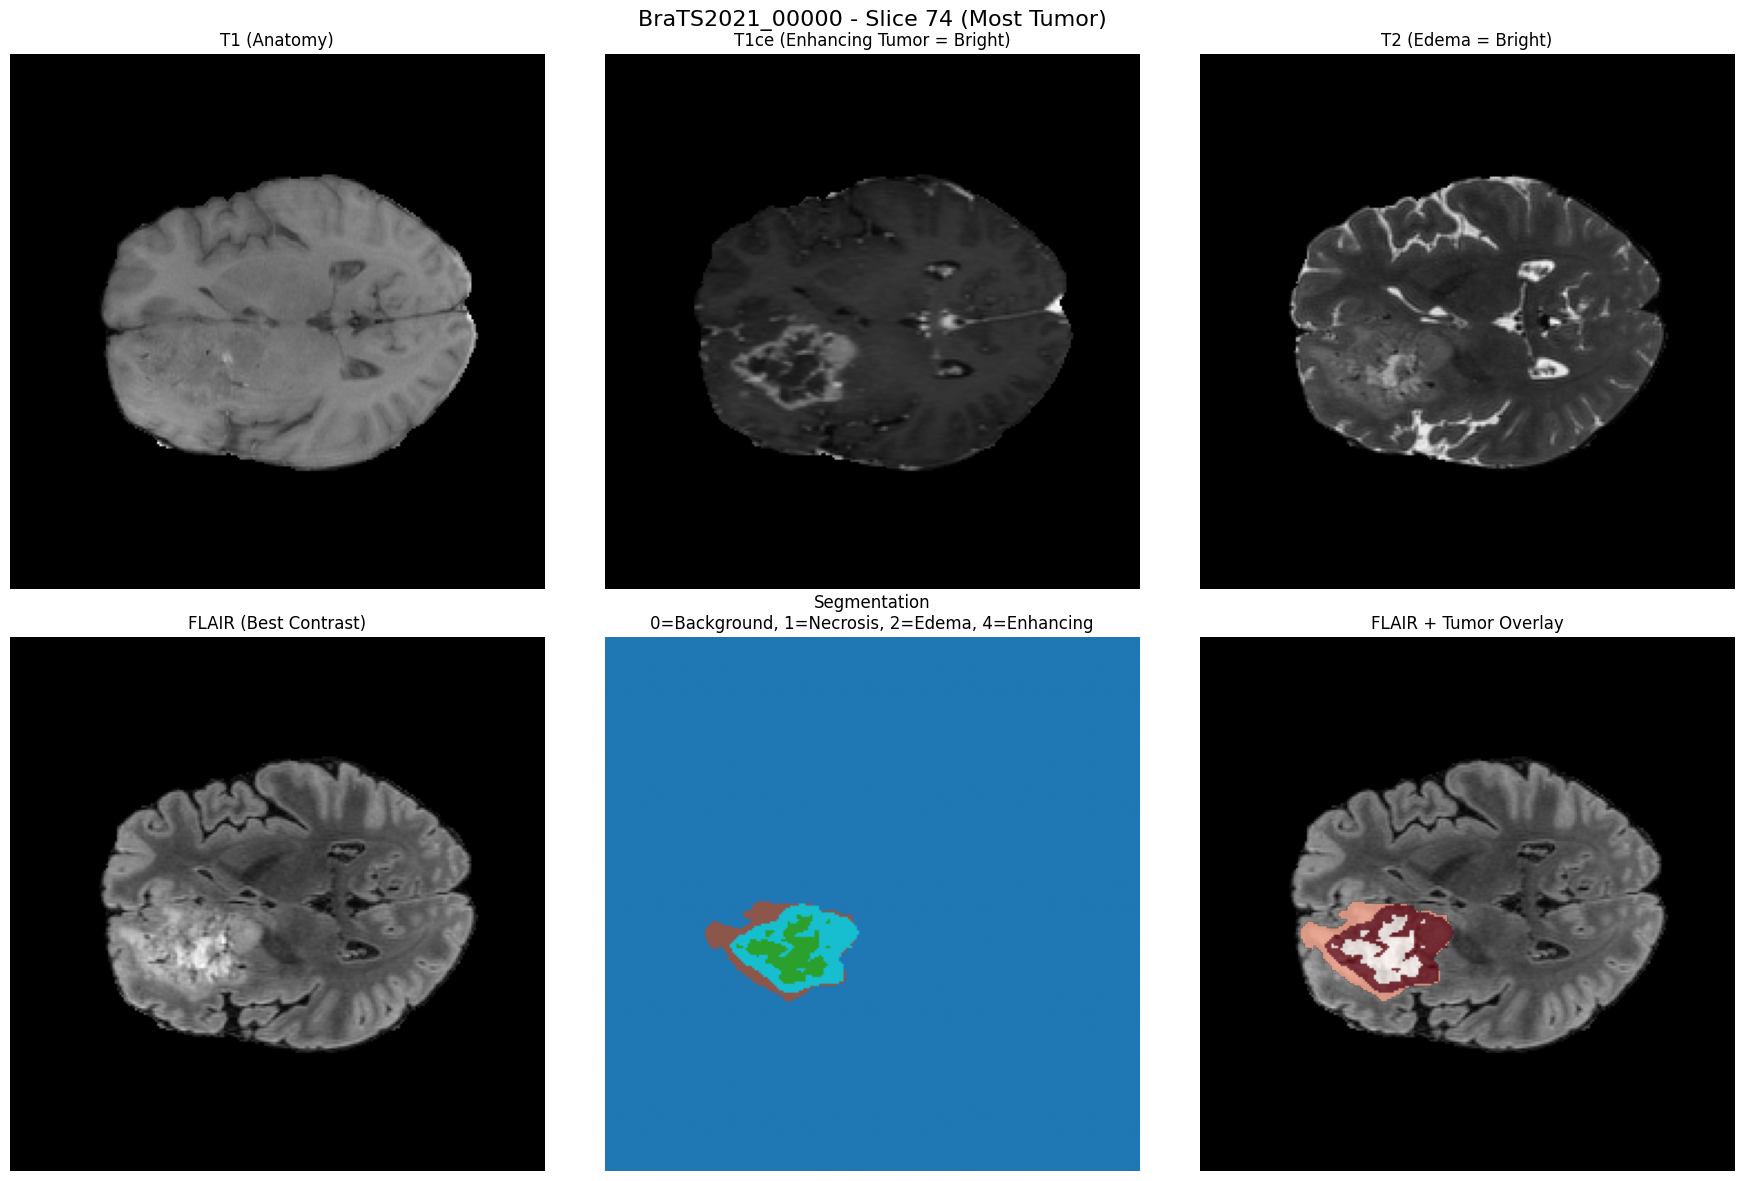

In [6]:
# Visualize all modalities for the best slice
slice_idx = best_slice

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'{case_name} - Slice {slice_idx} (Most Tumor)', fontsize=16)

# T1
axes[0,0].imshow(t1[:, :, slice_idx], cmap='gray')
axes[0,0].set_title('T1 (Anatomy)')
axes[0,0].axis('off')

# T1ce  
axes[0,1].imshow(t1ce[:, :, slice_idx], cmap='gray')
axes[0,1].set_title('T1ce (Enhancing Tumor = Bright)')
axes[0,1].axis('off')

# T2
axes[0,2].imshow(t2[:, :, slice_idx], cmap='gray')
axes[0,2].set_title('T2 (Edema = Bright)')
axes[0,2].axis('off')

# FLAIR
axes[1,0].imshow(flair[:, :, slice_idx], cmap='gray')
axes[1,0].set_title('FLAIR (Best Contrast)')
axes[1,0].axis('off')

# Segmentation
seg_slice = seg[:, :, slice_idx]
im = axes[1,1].imshow(seg_slice, cmap='tab10', vmin=0, vmax=4)
axes[1,1].set_title('Segmentation\n0=Background, 1=Necrosis, 2=Edema, 4=Enhancing')
axes[1,1].axis('off')

# Overlay segmentation on FLAIR
axes[1,2].imshow(flair[:, :, slice_idx], cmap='gray')
tumor_mask = seg_slice > 0
axes[1,2].imshow(np.ma.masked_where(~tumor_mask, seg_slice), cmap='Reds', alpha=0.7)
axes[1,2].set_title('FLAIR + Tumor Overlay')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Show segmentation label breakdown
unique_labels, counts = np.unique(seg, return_counts=True)

label_names = {
    0: 'Background',
    1: 'Necrotic core', 
    2: 'Peritumoral edema',
    4: 'Enhancing tumor'
}

print(f"Segmentation Label Breakdown for {case_name}:")
for label, count in zip(unique_labels, counts):
    percentage = (count / seg.size) * 100
    print(f"  {label}: {label_names.get(int(label), 'Unknown')} - {count:,} pixels ({percentage:.2f}%)")

Segmentation Label Breakdown for BraTS2021_00000:
  0.0: Background - 8,870,695 pixels (99.36%)
  1.0: Necrotic core - 11,738 pixels (0.13%)
  2.0: Peritumoral edema - 12,836 pixels (0.14%)
  4.0: Enhancing tumor - 32,731 pixels (0.37%)


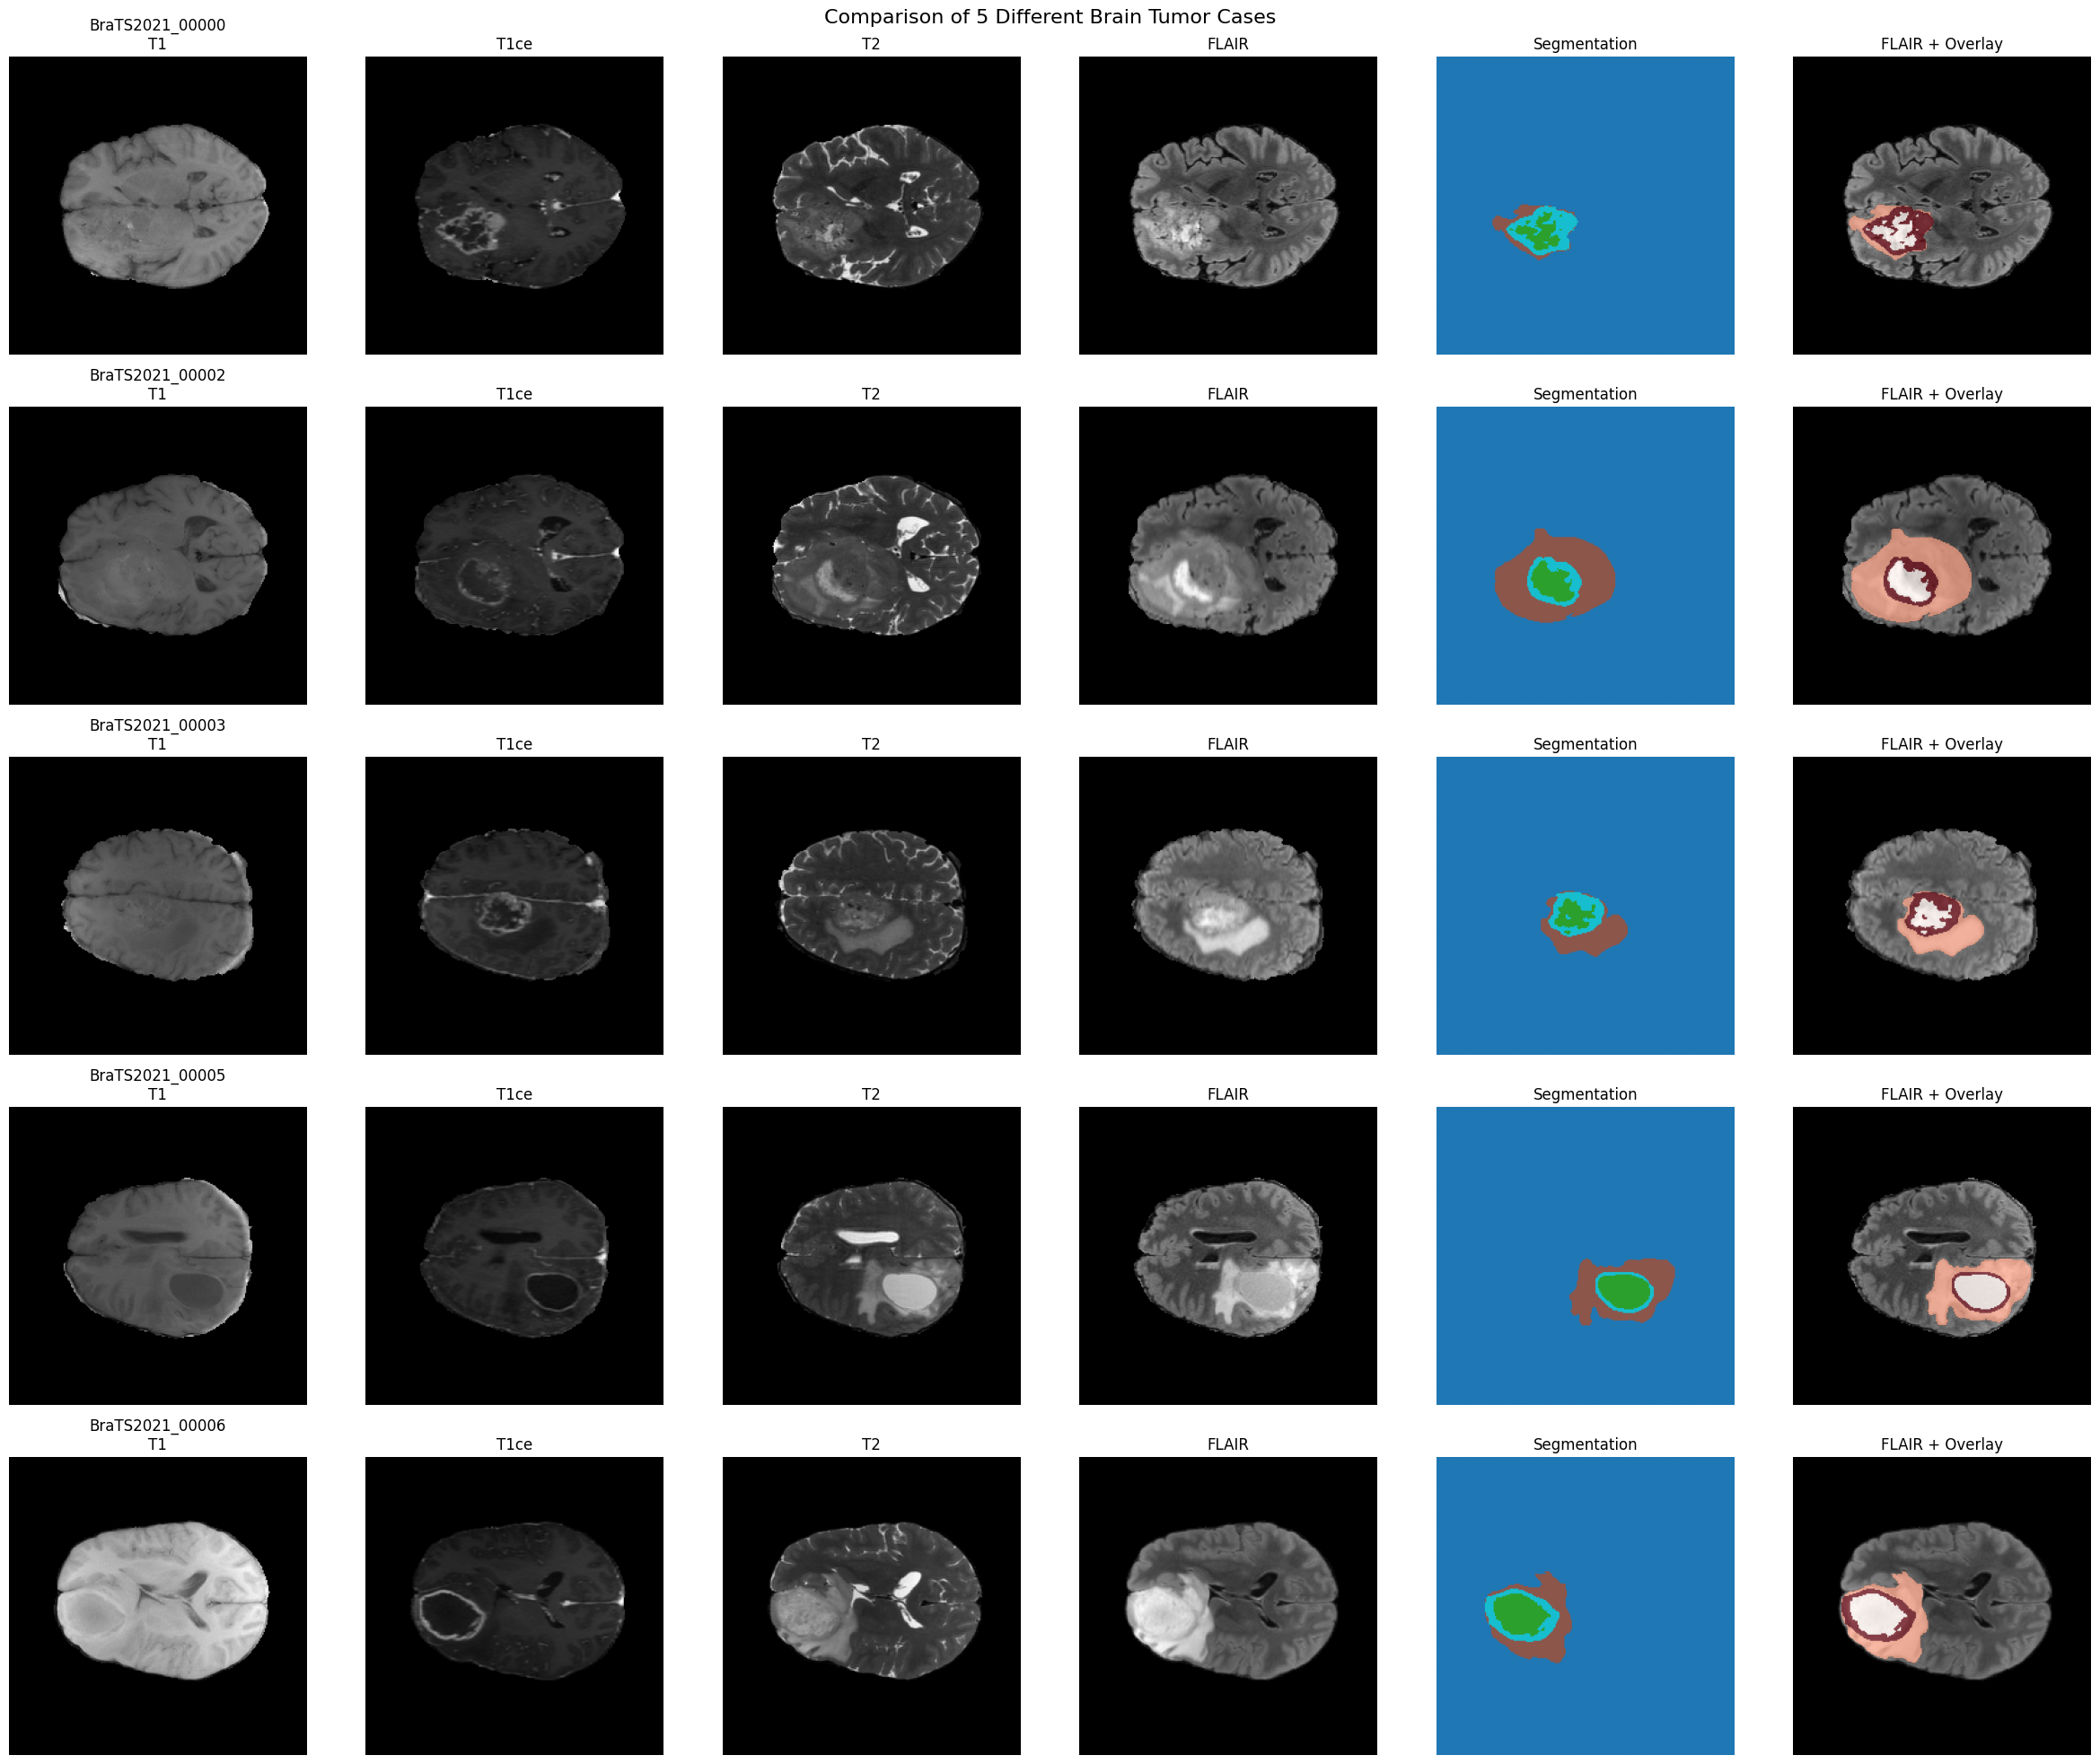

In [8]:
# Compare 5 different cases
fig, axes = plt.subplots(5, 6, figsize=(24, 20))
fig.suptitle('Comparison of 5 Different Brain Tumor Cases', fontsize=16)

for i in range(5):
    case_dir = case_dirs[i]
    case_name = case_dir.name
    
    # Load data
    t1 = nib.load(case_dir / f"{case_name}_t1.nii.gz").get_fdata()
    t1ce = nib.load(case_dir / f"{case_name}_t1ce.nii.gz").get_fdata()
    t2 = nib.load(case_dir / f"{case_name}_t2.nii.gz").get_fdata()
    flair = nib.load(case_dir / f"{case_name}_flair.nii.gz").get_fdata()
    seg = nib.load(case_dir / f"{case_name}_seg.nii.gz").get_fdata()
    
    # Find best slice
    tumor_per_slice = [np.sum(seg[:, :, j] > 0) for j in range(seg.shape[2])]
    best_slice = np.argmax(tumor_per_slice)
    
    # Plot modalities
    axes[i, 0].imshow(t1[:, :, best_slice], cmap='gray')
    axes[i, 0].set_title(f'{case_name}\nT1')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(t1ce[:, :, best_slice], cmap='gray')
    axes[i, 1].set_title('T1ce')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(t2[:, :, best_slice], cmap='gray')
    axes[i, 2].set_title('T2')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(flair[:, :, best_slice], cmap='gray')
    axes[i, 3].set_title('FLAIR')
    axes[i, 3].axis('off')
    
    axes[i, 4].imshow(seg[:, :, best_slice], cmap='tab10', vmin=0, vmax=4)
    axes[i, 4].set_title('Segmentation')
    axes[i, 4].axis('off')
    
    # Overlay
    axes[i, 5].imshow(flair[:, :, best_slice], cmap='gray')
    tumor_mask = seg[:, :, best_slice] > 0
    axes[i, 5].imshow(np.ma.masked_where(~tumor_mask, seg[:, :, best_slice]), cmap='Reds', alpha=0.7)
    axes[i, 5].set_title('FLAIR + Overlay')
    axes[i, 5].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Analyze tumor characteristics across multiple cases
print("Tumor Analysis Across Multiple Cases:")
print("="*50)

for i in range(10):  # Analyze first 10 cases
    case_dir = case_dirs[i]
    case_name = case_dir.name
    
    # Load segmentation
    seg = nib.load(case_dir / f"{case_name}_seg.nii.gz").get_fdata()
    
    # Calculate tumor statistics
    total_pixels = seg.size
    background_pixels = np.sum(seg == 0)
    necrosis_pixels = np.sum(seg == 1)
    edema_pixels = np.sum(seg == 2)
    enhancing_pixels = np.sum(seg == 4)
    total_tumor_pixels = necrosis_pixels + edema_pixels + enhancing_pixels
    
    # Find best slice
    tumor_per_slice = [np.sum(seg[:, :, j] > 0) for j in range(seg.shape[2])]
    best_slice = np.argmax(tumor_per_slice)
    max_tumor_in_slice = max(tumor_per_slice)
    
    print(f"{case_name}:")
    print(f"  Total tumor: {total_tumor_pixels:,} pixels ({total_tumor_pixels/total_pixels*100:.1f}%)")
    print(f"  Best slice: {best_slice} with {max_tumor_in_slice} tumor pixels")
    print(f"  Necrosis: {necrosis_pixels:,}, Edema: {edema_pixels:,}, Enhancing: {enhancing_pixels:,}")
    print()

Tumor Analysis Across Multiple Cases:
BraTS2021_00000:
  Total tumor: 57,305 pixels (0.6%)
  Best slice: 74 with 1978 tumor pixels
  Necrosis: 11,738, Edema: 12,836, Enhancing: 32,731

BraTS2021_00002:
  Total tumor: 190,594 pixels (2.1%)
  Best slice: 78 with 5220 tumor pixels
  Necrosis: 11,248, Edema: 155,695, Enhancing: 23,651

BraTS2021_00003:
  Total tumor: 99,239 pixels (1.1%)
  Best slice: 109 with 2572 tumor pixels
  Necrosis: 17,214, Edema: 57,773, Enhancing: 24,252

BraTS2021_00005:
  Total tumor: 124,783 pixels (1.4%)
  Best slice: 100 with 3409 tumor pixels
  Necrosis: 24,187, Edema: 76,742, Enhancing: 23,854

BraTS2021_00006:
  Total tumor: 137,911 pixels (1.5%)
  Best slice: 69 with 3600 tumor pixels
  Necrosis: 25,506, Edema: 85,957, Enhancing: 26,448

BraTS2021_00008:
  Total tumor: 18,462 pixels (0.2%)
  Best slice: 71 with 785 tumor pixels
  Necrosis: 16, Edema: 18,135, Enhancing: 311

BraTS2021_00009:
  Total tumor: 27,453 pixels (0.3%)
  Best slice: 90 with 796 tum

Exploring different cases:
Exploring BraTS2021_00000 (Case 0)


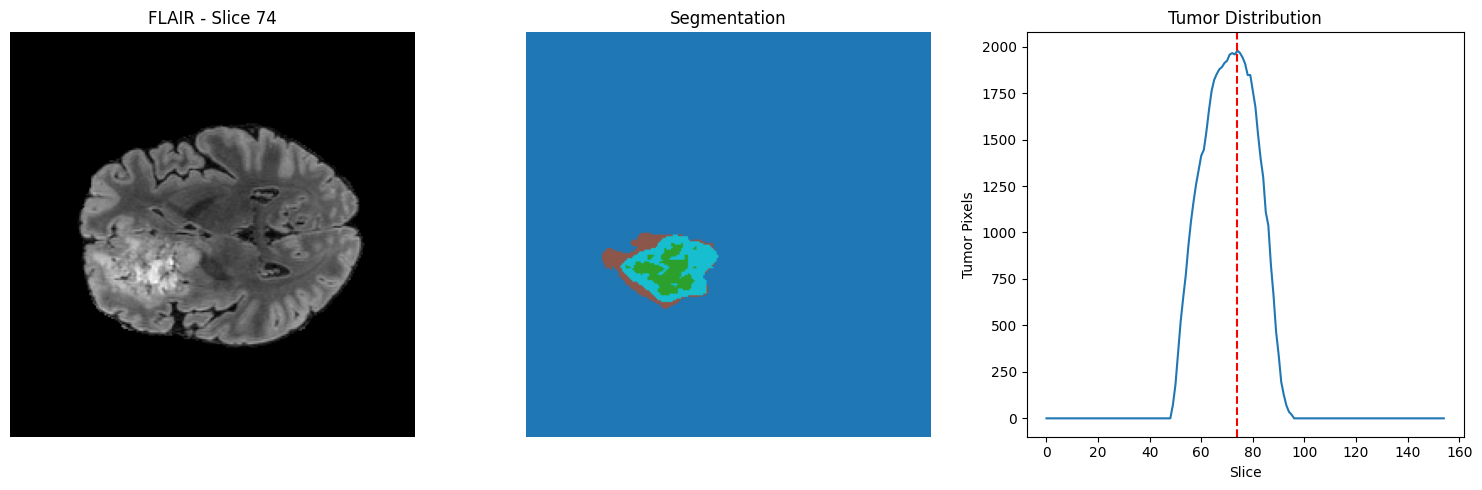

Case 0: Best slice = 74

Exploring BraTS2021_00008 (Case 5)


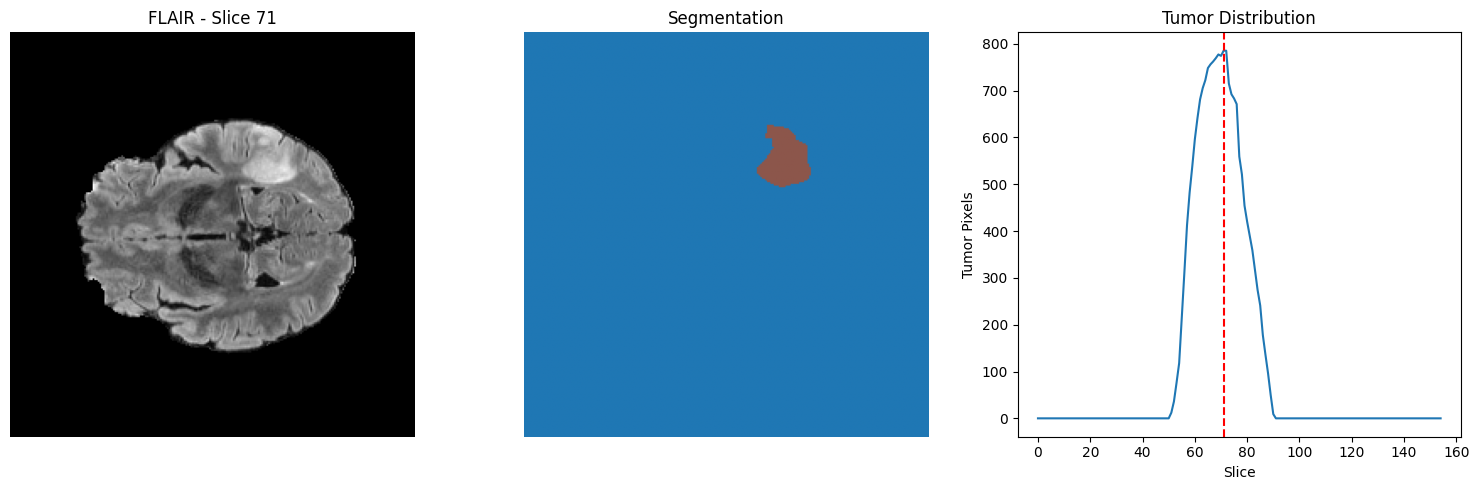

Case 5: Best slice = 71

Exploring BraTS2021_00016 (Case 10)


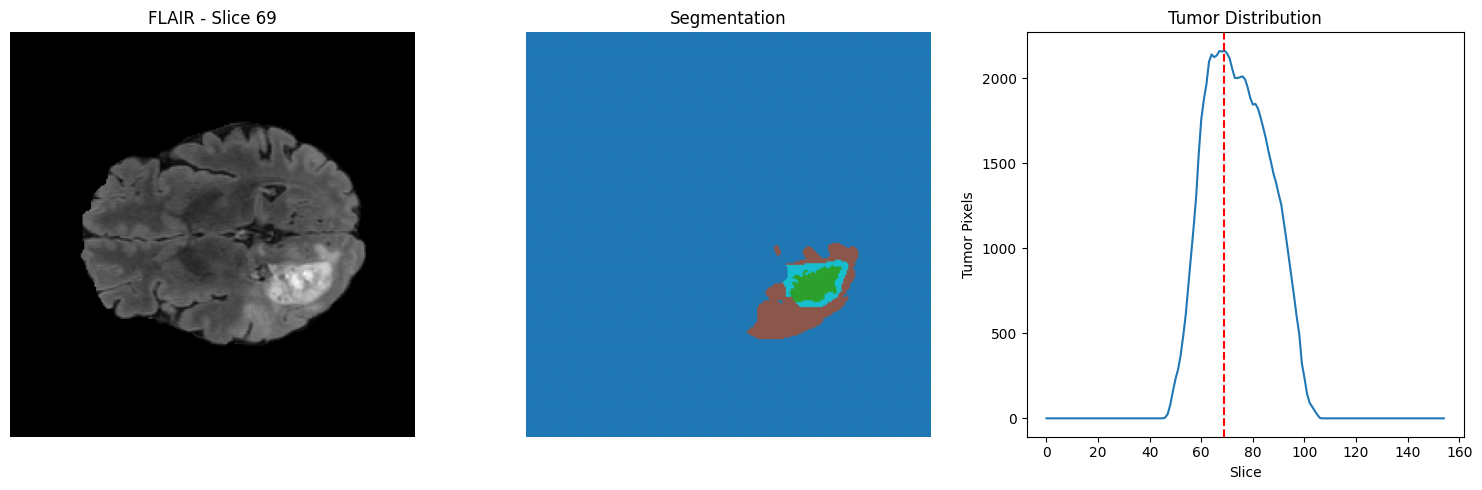

Case 10: Best slice = 69

Exploring BraTS2021_00021 (Case 15)


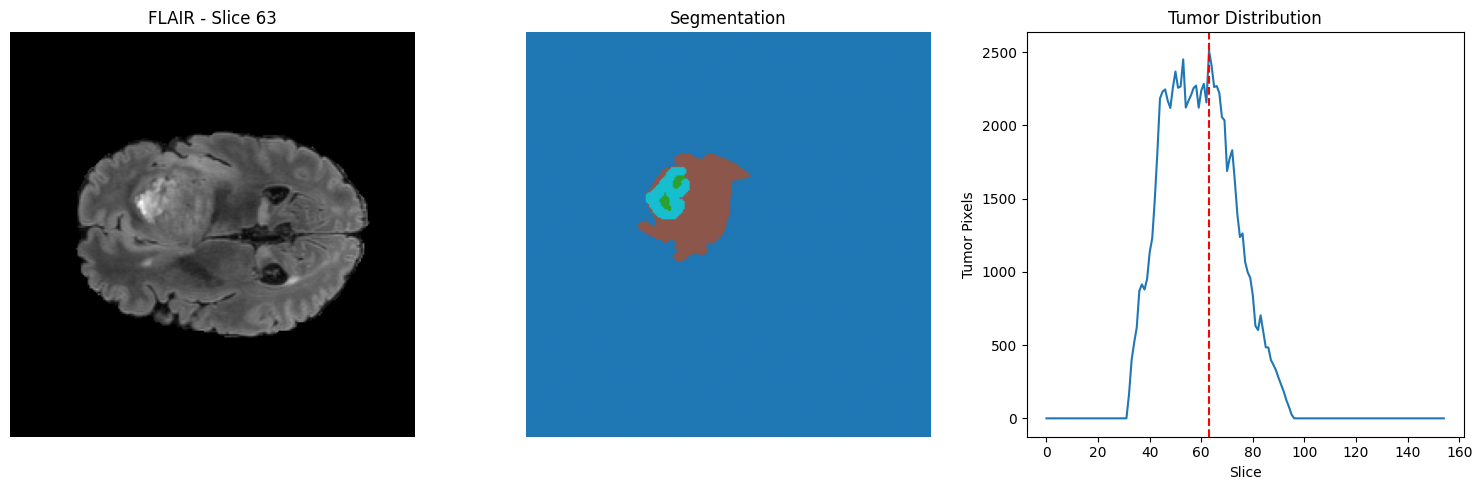

Case 15: Best slice = 63

Exploring BraTS2021_00028 (Case 20)


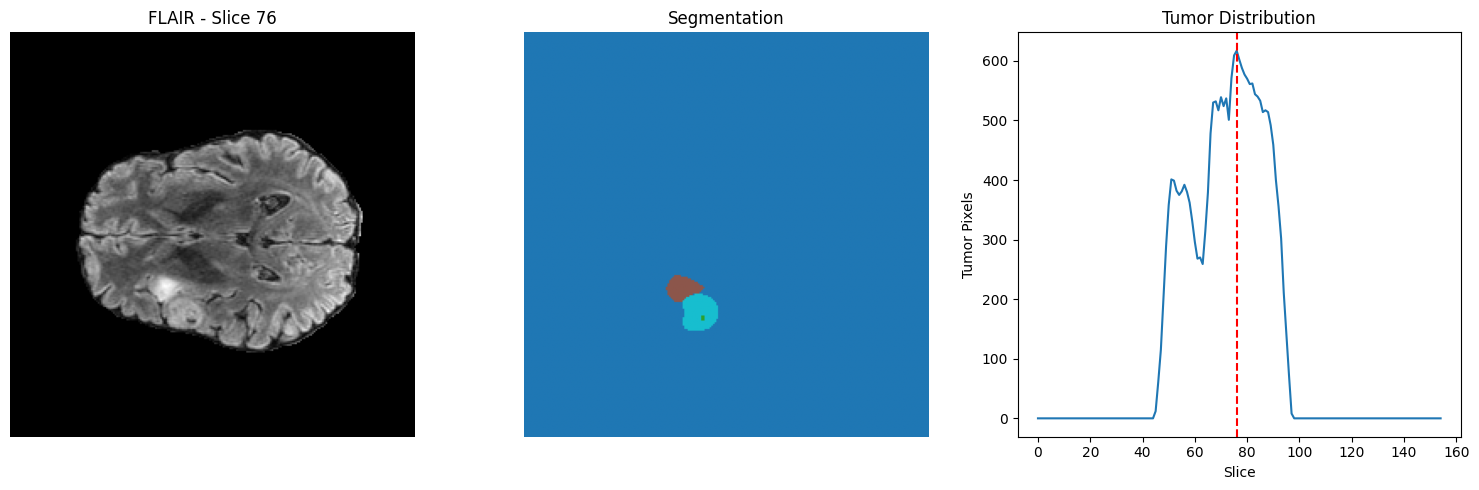

Case 20: Best slice = 76



In [10]:
# Function to quickly explore any case
def explore_case(case_index):
    case_dir = case_dirs[case_index]
    case_name = case_dir.name
    
    print(f"Exploring {case_name} (Case {case_index})")
    
    # Load all data
    t1 = nib.load(case_dir / f"{case_name}_t1.nii.gz").get_fdata()
    t1ce = nib.load(case_dir / f"{case_name}_t1ce.nii.gz").get_fdata()
    t2 = nib.load(case_dir / f"{case_name}_t2.nii.gz").get_fdata()
    flair = nib.load(case_dir / f"{case_name}_flair.nii.gz").get_fdata()
    seg = nib.load(case_dir / f"{case_name}_seg.nii.gz").get_fdata()
    
    # Find best slice
    tumor_per_slice = [np.sum(seg[:, :, j] > 0) for j in range(seg.shape[2])]
    best_slice = np.argmax(tumor_per_slice)
    
    # Quick visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(flair[:, :, best_slice], cmap='gray')
    axes[0].set_title(f'FLAIR - Slice {best_slice}')
    axes[0].axis('off')
    
    axes[1].imshow(seg[:, :, best_slice], cmap='tab10', vmin=0, vmax=4)
    axes[1].set_title('Segmentation')
    axes[1].axis('off')
    
    axes[2].plot(tumor_per_slice)
    axes[2].axvline(best_slice, color='red', linestyle='--')
    axes[2].set_title('Tumor Distribution')
    axes[2].set_xlabel('Slice')
    axes[2].set_ylabel('Tumor Pixels')
    
    plt.tight_layout()
    plt.show()
    
    return best_slice

# Try different cases
print("Exploring different cases:")
for case_idx in [0, 5, 10, 15, 20]:
    best_slice = explore_case(case_idx)
    print(f"Case {case_idx}: Best slice = {best_slice}\n")